# imgtofmri
## Overview of python package

Recent research has shown promise in predicting human fMRI activity in the visual cortex using artificial neural networks trained on computer vision tasks. Many of these neural networks, usually convolutional neural networks (CNNs), learn hierarchial representations of visual input that look similar to how we believe the human visual cortex to be mapped -- edges combining to form textures, textures combining to form more semantic features such as size or animacy.

We build on this research, as well as on the open source BOLD5000 dataset and pretrained ResNet model as our CNN, to create a package for predicting group-averaged fMRI activity from images or movies.

<center>
<img src="img/overview.png" alt="drawing" width="500" align="center"/>
</center>

In this notebook, we overview use of the package, imgtofmri, as well as demonstrate the model's extension and prediction power to novel datasets not used in the training of the model.

## Using imgtofmri on an unseen dataset
We first show how we can use imgtofmri to predict fMRI responses to out-of-dataset images. We perform this on the [Twinset Dataset](http://twinsetfusion.csail.mit.edu/) compiled by Mohsenzadeh et al. This dataset is comprised of fMRI data for 33 adults viewing 156 images. These images are split across 5 categories:

<center>
<img src="img/twinset_cropped.png" alt="drawing" width="300" align="center"/>
</center>

We proceed by:
<ol>
<li>Downloading this dataset</li>
<li>Pushing it through our model with the imgtofmri.predict() function</li>
<li>Analyzing performance:</li>
    <ol>
<li>With the whole group</li>
<li>Within categories</li>
<li>Within subjects</li>
    </ol>
</ol>

In [4]:
%load_ext autoreload
%autoreload 2
import imgtofmri

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
input_dir = 'input_images/156ImageStimuliSet/'
output_dir = 'output_testing_aperture/'

# Options for ROIs are: EarlyVis, OPA, LOC, PPA, RSC
# We use LOC, PPA, and RSC for our tutorial, as they performed strongest above chance
rois = ['LOC', 'PPA', 'RSC']

In [8]:
!pwd

/Users/maxwellbennett/Research/imgtofmri


In [4]:
url = 'http://wednesday.csail.mit.edu/fusion_rep/stimulus/156ImageStimuliSet.zip'
imgtofmri.load_imgs(url)

Downloaded and extracted: 156ImageStimuliSet (3).zip


In [3]:
imgtofmri.predict(input_dir, output_dir, rois)

Averaging MNI brains: 100%|██████████| 157/157 [00:13<00:00, 11.83it/s]


### Twinset Analyses

In [4]:
imgtofmri.twinset_generate_group_correlations(output_dir)

100%|██████████| 156/156 [07:19<00:00,  2.82s/it]


Real difference:      0.048752
Mean null difference: -0.000037
p value:              0.000100
norm.sf:              0.000000



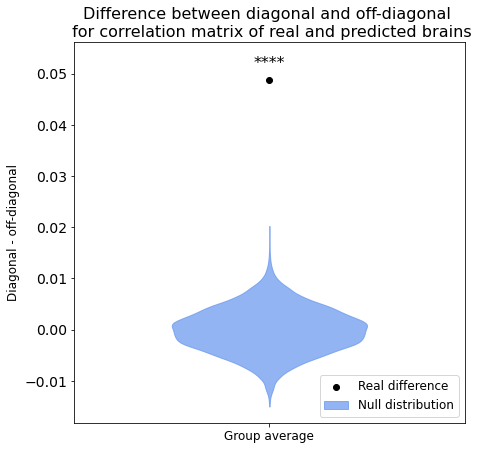

In [9]:
imgtofmri.twinset_random_group_permutations(n_shuffle=10000, print_vals=True)

In [3]:
imgtofmri.twinset_generate_category_correlations(output_dir)

Generating correlations for 'faces': 100%|██████████| 32/32 [00:19<00:00,  1.61it/s]


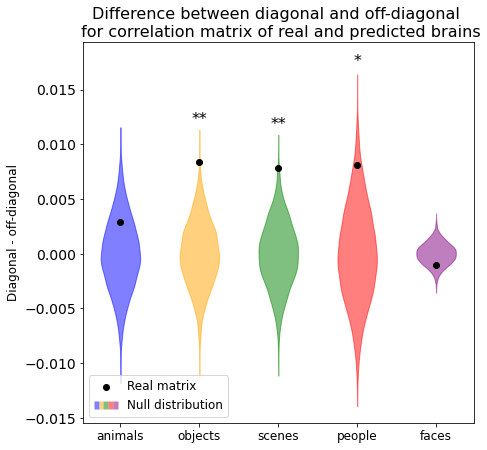

In [6]:
# imgtofmri.twinset_random_category_permutations(n_shuffle=1000, print_vals=True)
imgtofmri.twinset_random_category_permutations(n_shuffle=10000)

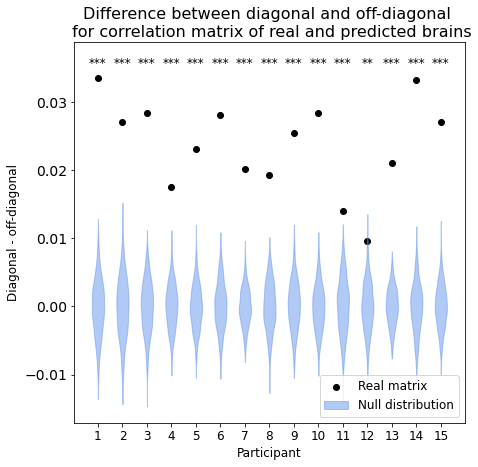

In [7]:
imgtofmri.twinset_random_participant_permutations(n_shuffle=1000)

### Generalizing image prediction to movies (Partly Cloudy)

In [10]:
from imgtofmri import *

In [14]:
true_dir = "../pc_true/preprocessed_data"
output_dir = "output/"
input_dir = "../partly_cloudy/"
overlap = get_subj_overlap()

In [15]:
# Loading predicted brains
pred = nib.load(f'{output_dir}/pred_avg_ra_dcto.nii.gz').get_fdata()
pred = pred[:,:,:,2:-8]
pred = np.corrcoef(pred[overlap].T)
# plt.imshow(pred)

In [16]:
# Loading Luminance model as comparison
lum = get_luminance(input_dir)
lum = np.corrcoef(lum)

Downsampling: 100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


In [17]:
# Loading True brains
true = nib.load(f'{true_dir}/avg_r_ro_m_s_z_ra_dcto.nii.gz').get_fdata()
true = true[:,:,:,10:]
true = np.corrcoef(true[overlap].T)
# plt.imshow(true)

Text(0.5, 0.98, 'Correlation matrices for Partly Cloudy')

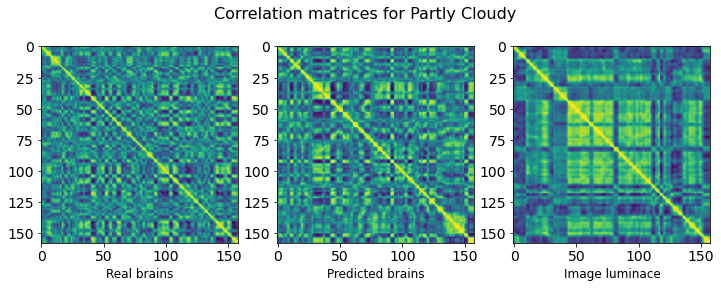

In [18]:
# Correlation matrices
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
axes[0].imshow(true)
axes[1].imshow(pred)
axes[2].imshow(lum)
axes[0].set_xlabel('Real brains', fontsize=12)
axes[1].set_xlabel('Predicted brains', fontsize=12)
axes[2].set_xlabel('Image luminace', fontsize=12)
fig.suptitle('Correlation matrices for Partly Cloudy', fontsize=16)

### Comparing performance between Predicted brains + Luminance model

In [19]:
corr = generate_bootstrapped_correlations(true, pred, lum, TR_band=None)

Generating and loading bootstraps: 100%|██████████| 100/100 [05:51<00:00,  3.52s/it]


#### On the full movie timecourse

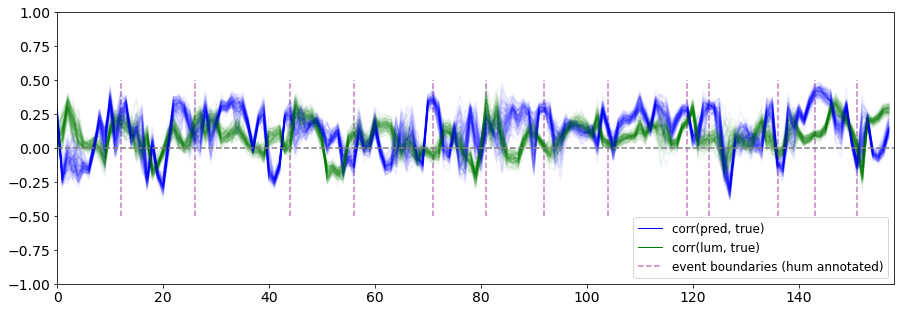

In [24]:
imgtofmri.pc_pred_lum_timecourse(corr)

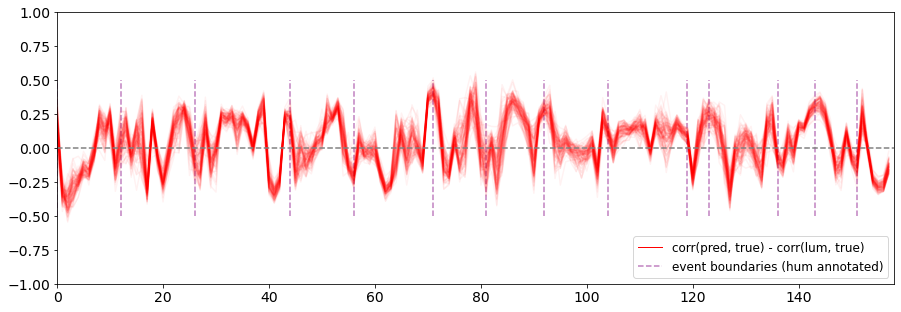

In [25]:
pc_difference_timecourse(corr)

#### Boundary triggered averages with bootstraps

In [22]:
bound_averages = generate_boundary_triggered_averages(corr)

Generating bootstrapped boundaries: 100%|██████████| 1000/1000 [00:10<00:00, 99.35it/s]


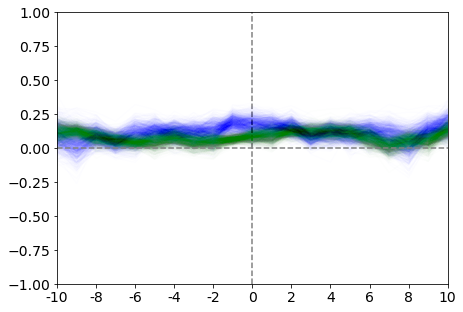

In [30]:
pc_bootstrapped_pred_lum(bound_averages)

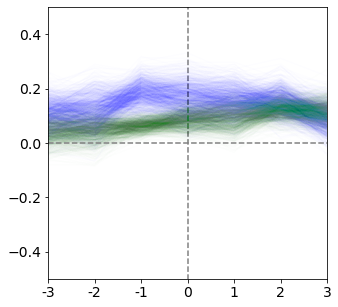

In [42]:
pc_bootstrapped_pred_lum_3TRs(bound_averages)

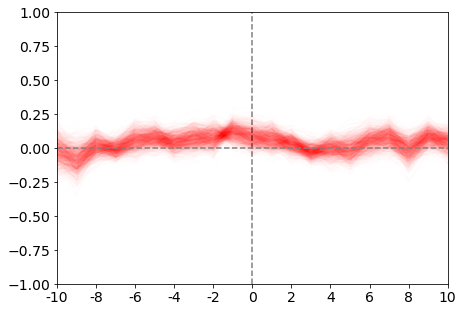

In [32]:
pc_bootstrapped_difference(bound_averages)

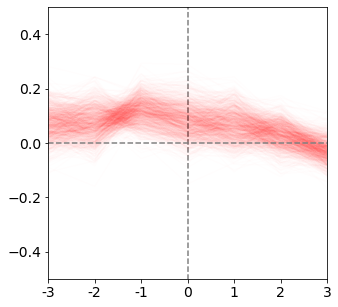

In [43]:
pc_bootstrapped_difference_3TRs(bound_averages)

In [34]:
num_below_zero = np.zeros((7))
for i in range(0, 7):
    for b in range(1000):
        if bound_averages[0,7+i,b]-bound_averages[1,7+i,b] < 0:
            num_below_zero[i] += 1

print(num_below_zero/1000)

[0.102 0.1   0.008 0.071 0.123 0.263 0.768]


In [35]:
bound_diffs = np.zeros((21,1000))
for i in range(0,21):
    for b in range(1000):
        bound_diffs[i,b] = bound_averages[0,i,b] - bound_averages[1,i,b]
        
num_better_than_boundary = 0
for b in range(1000):
    if (bound_diffs[7:10,b] > bound_diffs[10,b]).any() or (bound_diffs[11:14,b] > bound_diffs[10,b]).any():
        num_better_than_boundary += 1

print(num_better_than_boundary)

914


## ±10 TRs

In [47]:
corr = generate_bootstrapped_correlations(true, pred, lum, TR_band=10)

Generating and loading bootstraps: 100%|██████████| 100/100 [05:51<00:00,  3.51s/it]


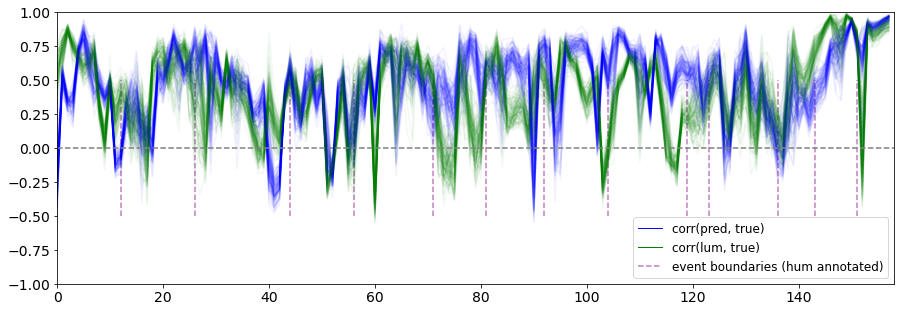

In [48]:
pc_pred_lum_timecourse(corr)

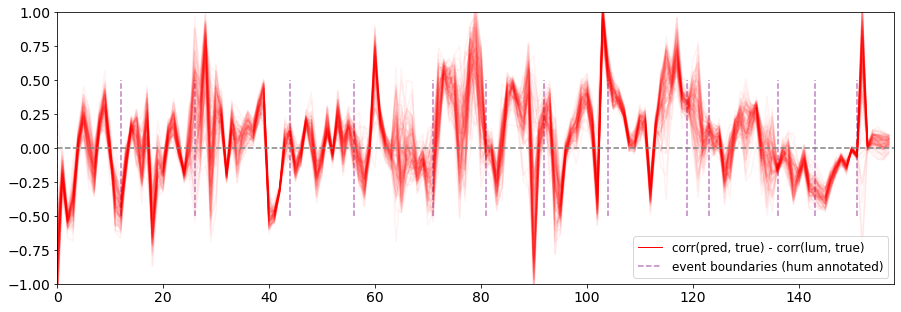

In [49]:
pc_difference_timecourse(corr)

## Boundary triggered averages

In [50]:
bound_averages = generate_boundary_triggered_averages(corr)

Generating bootstrapped boundaries: 100%|██████████| 1000/1000 [00:09<00:00, 103.23it/s]


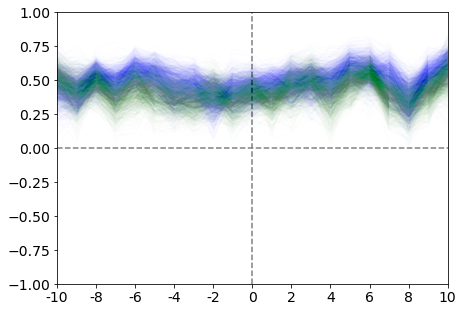

In [51]:
pc_bootstrapped_pred_lum(bound_averages)

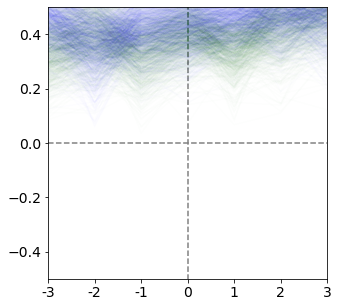

In [52]:
pc_bootstrapped_pred_lum_3TRs(bound_averages)

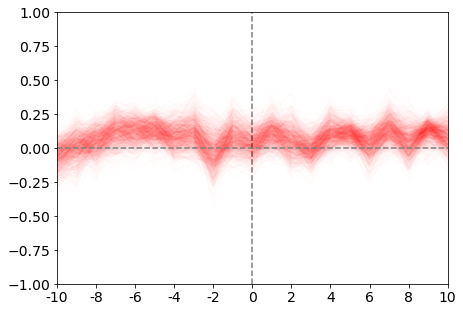

In [53]:
pc_bootstrapped_difference(bound_averages)

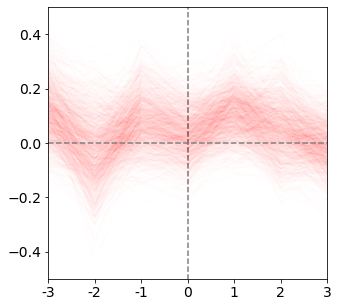

In [54]:
pc_bootstrapped_difference_3TRs(bound_averages)

In [55]:
num_below_zero = np.zeros((7))
for i in range(0, 7):
    for b in range(1000):
        if bound_averages[0,7+i,b]-bound_averages[1,7+i,b] < 0:
            num_below_zero[i] += 1

print(num_below_zero/1000)

[0.127 0.584 0.196 0.338 0.091 0.306 0.533]


In [56]:
bound_diffs = np.zeros((21,1000))
for i in range(0,21):
    for b in range(1000):
        bound_diffs[i,b] = bound_averages[0,i,b] - bound_averages[1,i,b]
        
num_better_than_boundary = 0
for b in range(1000):
    if (bound_diffs[7:10,b] > bound_diffs[10,b]).any() or (bound_diffs[11:14,b] > bound_diffs[10,b]).any():
        num_better_than_boundary += 1

print(num_better_than_boundary)

980


### bandwidth testing

In [24]:
nTR = true.shape[0]
corr = np.zeros((2, nTR//2, nTR)) # pred,lum x band_width x corr(each_row) 
for b in range (1,nTR//2):
    upt = ~np.triu(np.ones(nTR).astype(bool), b + 1) # upper triangle of 0s
    lot = np.triu(np.ones(nTR).astype(bool), -b) # lower triangle of 0s
    band = upt & lot
    notdiag = 1-np.diag(np.ones(158)).astype(bool)
    band = band & notdiag
    band = band.astype(bool)
#     print(band[-2])
#     print(band[nTR//2])
#     print(np.count_nonzero(band[nTR//2]))
    for i in range(1, nTR-1):
        corr[0,b,i] = stats.pearsonr(pred[i][band[i]], true[i][band[i]])[0]
        corr[1,b,i] = stats.pearsonr(lum[i][band[i]], true[i][band[i]])[0]

mean_corr = np.zeros((2,nTR//2))
for b in range(1, nTR//2):
    mean_corr[0,b] = np.mean(corr[0,b,:])
    mean_corr[1,b] = np.mean(corr[1,b,:])

Text(0.5, 1.0, 'mean correlation of row x row corrs from TRxTR matrices')

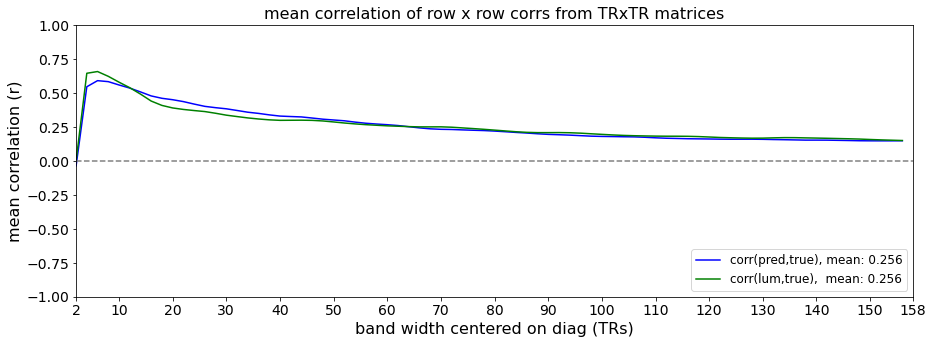

In [25]:
import matplotlib.ticker as ticker
plt.figure(figsize=(15, 5))
plt.tick_params(axis='x', top=False, labeltop=False)
plt.plot(mean_corr[0], color='blue', label=f'corr(pred,true), mean: {np.mean(corr[0]):.3f}')
plt.plot(mean_corr[1], color='green', label=f'corr(lum,true),  mean: {np.mean(corr[1]):.3f}')
axes = plt.gca()
axes.set_ylim([-1,1])
axes.set_xlim([1,nTR//2])
axes.set_ylabel("mean correlation (r)")
axes.set_xlabel("band width centered on diag (TRs)")

ticks = [i for i in np.concatenate(([2], np.arange(10,  nTR, step=10), [nTR]))/2]
ticklabels = [f'{i:.0f}' for i in np.concatenate(([2], np.arange(10,  nTR, step=10), [nTR]))]
axes.set_xticks(ticks)
axes.set_xticklabels(ticklabels)

plt.axhline(0, 0, nTR, linestyle='dashed', color='grey')
# plt.vlines(3, -.5,.5, linestyle='dashed', color='red', alpha=0.5, label="event boundaries (hum annotated)")
plt.legend(fontsize='large', loc='lower right')
plt.title("mean correlation of row x row corrs from TRxTR matrices")

In [ ]:
# HMM fits

In [2]:
%env PATH=/Users/maxwellbennett/abin:/Users/maxwellbennett/opt/anaconda3/envs/venv/bin:/Users/maxwellbennett/opt/anaconda3/condabin:/usr/local/sbin:/Users/maxwellbennett/google-cloud-sdk/bin:/usr/local/fsl/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/go/bin:/opt/X11/bin:/Library/Apple/usr/bin:/Library/Frameworks/Mono.framework/Versions/Current/Commands

env: PATH=/Users/maxwellbennett/abin:/Users/maxwellbennett/opt/anaconda3/envs/venv/bin:/Users/maxwellbennett/opt/anaconda3/condabin:/usr/local/sbin:/Users/maxwellbennett/google-cloud-sdk/bin:/usr/local/fsl/bin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/usr/local/go/bin:/opt/X11/bin:/Library/Apple/usr/bin:/Library/Frameworks/Mono.framework/Versions/Current/Commands


#### Notes
- rewrite check for file suffix to be fn with list from beginning?

## Appendix

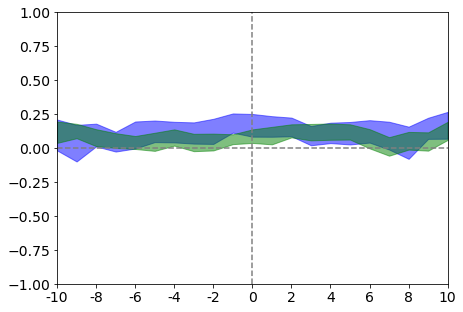

In [38]:
imgtofmri.pc_bootstrapped_pred_lum_conf_intervals(bound_averages)

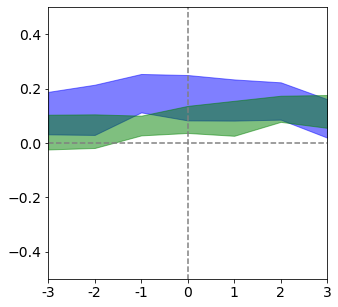

In [44]:
imgtofmri.pc_bootstrapped_pred_lum_3TRs_conf_intervals(bound_averages)

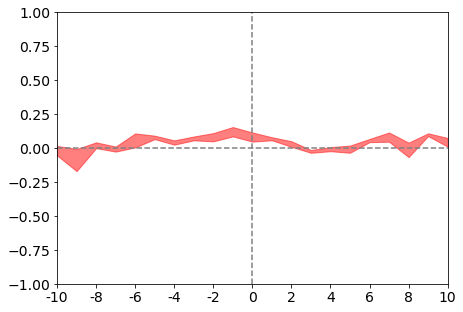

In [45]:
imgtofmri.pc_bootstrapped_difference_conf_intervals(bound_averages)

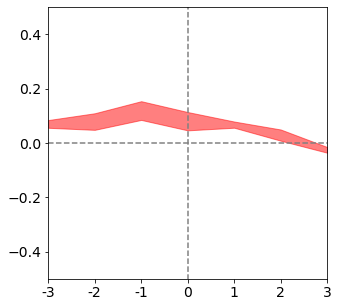

In [46]:
imgtofmri.pc_bootstrapped_difference_3TRs_conf_intervals(bound_averages)